In [2]:
import warnings
import sys
warnings.filterwarnings('ignore')
sys.path.append('../src')

# preprocess import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# custom functions
import config
from utils import make_train_test
from metric import NMAE, get_metrics
from data_connector import YeongGwang, GyeongJu, Target
from data_pipeline import *

# model import
import lightgbm as lgb
from lightgbm import LGBMRegressor

# 1. Load Scada

-- YG

In [5]:
scada_yg = pd.DataFrame()
for turbine_idx in range(1, 36):
    tmp = (pd.read_parquet(config.input_path + f"ewp004_2020_2022_WTG{turbine_idx}.parquet")
             .rename(columns = {'Date/Time': 'dt', 'WTG.Name': 'turbine_id', 'WTG. Name': 'turbine_id'}))
    scada_yg = pd.concat([scada_yg, tmp], axis=0)

idx = scada_yg.loc[scada_yg['dt'].isin(['Summation', 'Average', 'Standard Deviation'])].index
scada_yg.drop(idx, axis=0, inplace=True)

try:
    scada_yg['dt'] = (pd.to_datetime(scada_yg['dt'])
                      .dt
                      .tz_convert("Asia/Seoul"))

except TypeError:
    scada_yg['dt'] = (pd.to_datetime(scada_yg['dt'])
                      .dt
                      .tz_localize("Asia/Seoul"))
    
gc.collect();

-- GJ

In [6]:
scada_gj = pd.DataFrame()
for turbine_idx in range(1, 10):
    tmp = (pd.read_parquet(config.input_path + f"ewp02_2020_2022_WTG{turbine_idx}.parquet")
             .rename(columns = {'Date/Time': 'dt', 'WTG.Name': 'turbine_id', 'WTG. Name': 'turbine_id'}))
    scada_gj = pd.concat([scada_gj, tmp], axis=0)

idx = scada_gj.loc[scada_gj['dt'].isin(['Summation', 'Average', 'Standard Deviation'])].index
scada_gj.drop(idx, axis=0, inplace=True)

try:
    scada_gj['dt'] = (pd.to_datetime(scada_gj['dt'])
                      .dt
                      .tz_convert("Asia/Seoul"))
    
except TypeError:
    scada_gj['dt'] = (pd.to_datetime(scada_gj['dt'])
                      .dt
                      .tz_localize("Asia/Seoul"))
    
gc.collect();

# 2. Preprocessing

In [9]:
USE_COLS = [
    'wind_u_100m', 'wind_v_100m', 'wind_speed_100m',
    'temp_air', 'density', 'relative_humid', 'specific_humid',
    'frictional_vmax_50m', 'frictional_vmin_50m'
]

# Meteorological processing pipelines
def create_meteorological_pipeline(elevation, roughness):
    """Create a pipeline for meteorological data processing."""
    return Pipeline([
        ("uv_preprocess", WindVectorTransformer()),
        ("windspeed_preprocess", LogarithmicWindTransformer("wind_speed", elevation + 100, roughness)),
        ('basic_features', FeatureTransformer())
    ])
    
# Full pipelines
def create_pipeline(processor, scada, location):
    """Create a full pipeline for data transformation."""
    return Pipeline([
        ('preprocessor', processor),
        ('pivot', PivotTransformer('dt', 'turbine_id', USE_COLS)),
        ('weights', WeightsEncoder(scada)),
        ('datetime', DatetimeEncoder(location, encoding=True, verbose=True)),
        ('deviation', DeviationTransformer(verbose=True)),
        ('global', GlobalTransformer(verbose=True))
    ])

### Load LDAPS and Feature Engineering

In [ ]:
# Load data
ldaps_yg = YeongGwang().load(start_date='2020-01-01', 
                             end_date='2023-01-01')

ldaps_gj = GyeongJu().load(start_date='2020-01-01', 
                           end_date='2023-01-01')

# Feature Engineering Configuration
print('Feature Engineering')
print('-' * 50)

meteorological_process = {
    'yg': create_meteorological_pipeline(ldaps_yg['elevation'], ldaps_yg['surf_rough']),
    'gj': create_meteorological_pipeline(ldaps_gj['elevation'], ldaps_gj['surf_rough'])
}

YG_Pipeline = create_pipeline(
    meteorological_process['yg'], scada_yg, 'yg'
)

GJ_Pipeline = create_pipeline(
    meteorological_process['gj'], scada_gj, 'gj'
)

# Transform data
print('Processing Yeonggwang Data...')
ldaps_yg = YG_Pipeline.fit_transform(ldaps_yg)

print('=' * 30)
print('Processing Gyeongju Data...')
ldaps_gj = GJ_Pipeline.fit_transform(ldaps_gj)

# Garbage collection
gc.collect();

print('Done')
print('-' * 50)

--------------------------------------------------
Feature Engineering
Processing Yeonggwang Data...
create default time features
create season features
create day/night features
create hour ensemble feature
create day/night ensemble feature
create global aggregation feature
Processing Gyeongju Data...
create default time features
create season features
create day/night features
create hour ensemble feature
create day/night ensemble feature
create global aggregation feature
Done
--------------------------------------------------


### Load Target

In [14]:
train_y_yg = (Target("영광풍력")
              .load(start_date='2020-01-01', 
                    end_date='2023-01-01')
              .drop(['plant_name', 'period_hours'], axis=1))

train_y_gj = (Target("경주풍력")
              .load(start_date='2020-01-01', 
                    end_date='2023-01-01')
              .drop(['plant_name', 'period_hours'], axis=1))

# 3. Model Train

-- GJ

In [ ]:
import config
import joblib

FINAL = False

if not FINAL:
    X = ldaps_gj
    y = train_y_gj

    capacity = 20700

    _, x_train, x_test, y_train, y_test = make_train_test(X, y, test_size=0.2)

    # zero mean
    y_mean = y_train.mean()
    y_train -= y_mean

    model_gj = LGBMRegressor(**config.lgb_params['gj'])

    # train
    model_gj.fit(x_train, y_train)

    # predict
    y_pred = model_gj.predict(x_test)
    y_pred = np.clip(y_pred + y_mean, 0, capacity)

    NMAE(y_test, y_pred, capacity)
    _ = get_metrics(y_test, y_pred, capacity)

    # for check overfit
    print(model_gj.score(x_train, y_train))
    print(model_gj.score(x_test, (y_test - y_mean)))

else:
    # for final train
    tmp = pd.merge(ldaps_gj, train_y_gj[['dt', 'energy_kwh']], 
                   how='inner', 
                   on='dt')

    X = tmp.drop(['dt', 'energy_kwh'], axis=1)
    y = tmp['energy_kwh']

    y_mean = y.mean()
    y -= y_mean

    model_gj = LGBMRegressor(**config.lgb_params['gj'])
    model_gj.fit(X, y)

    print(model_gj.score(X, y))

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 68917
[LightGBM] [Info] Number of data points in the train set: 20961, number of used features: 276
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 276 dense feature groups (5.52 

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3


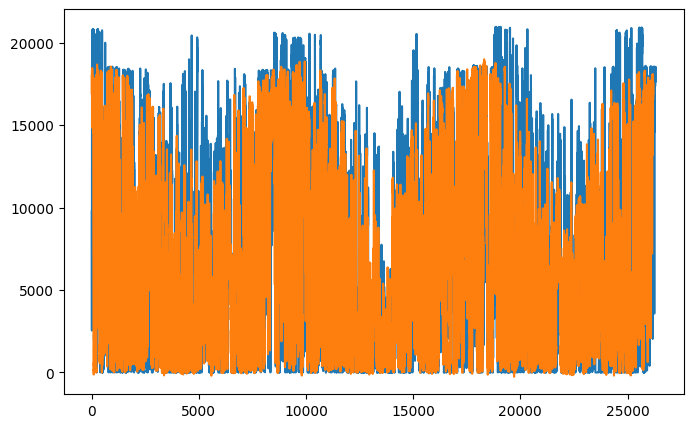

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(y['energy_kwh'])
plt.plot(model_gj.predict(X.drop(['dt'], axis=1)) + y_mean)
plt.show()

-- YG

In [ ]:
import config
import joblib

FINAL = False

if not FINAL:
    X = ldaps_yg
    y = train_y_yg

    capacity = 79600

    _, x_train, x_test, y_train, y_test = make_train_test(X, y, test_size=0.2)

    # zero mean
    y_mean = y_train.mean()
    y_train -= y_mean

    model_yg = LGBMRegressor(**config.lgb_params['yg'])

    # train
    model_yg.fit(x_train, y_train)

    # predict
    y_pred = model_yg.predict(x_test)
    y_pred = np.clip(y_pred + y_mean, 0, capacity)

    NMAE(y_test, y_pred, capacity)
    _ = get_metrics(y_test, y_pred, capacity)

    # for check overfit
    print(model_yg.score(x_train, y_train))
    print(model_yg.score(x_test, (y_test - y_mean)))

else:
    # for final train
    tmp = pd.merge(X, train_y_yg[['dt', 'energy_kwh']], 
                   how='inner', 
                   on='dt')

    X = tmp.drop(['dt', 'energy_kwh'], axis=1)
    y = tmp['energy_kwh']

    y_mean = y.mean()
    y -= y_mean

    model_yg = LGBMRegressor(**config.lgb_params['yg'])
    model_yg.fit(X, y)

    print(model_yg.score(X, y))

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 247927
[LightGBM] [Info] Number of data points in the train set: 20961, number of used features: 978
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 978 dense feature groups (19.5

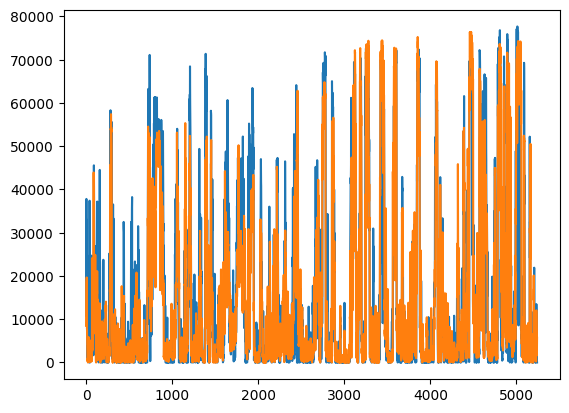

In [24]:
plt.plot(list(range(len(y_test))), y_test)
plt.plot(list(range(len(y_test))), y_pred)

-- Model Save

In [22]:
# import joblib

# joblib.dump(model_yg, config.model_output + 'lgb_yg_1029_total.pkl')
# joblib.dump(model_gj, config.model_output + 'lgb_gj_1029_total.pkl')

# 4. Inference

In [18]:
# Load data
submission = pd.read_csv(f"{config.input_path}submission_format.csv", encoding='euc-kr')
test_y_gj = pd.read_parquet(f"{config.input_path}test_ldaps_gyeongju.parquet")
test_y_yg = pd.read_parquet(f"{config.input_path}test_ldaps_yeonggwang.parquet")

# Feature Engineering Configuration
print('Feature Engineering')
print('-' * 50)

meteorological_process = {
    'yg': create_meteorological_pipeline(test_y_yg['elevation'], test_y_yg['surf_rough']),
    'gj': create_meteorological_pipeline(test_y_gj['elevation'], test_y_gj['surf_rough'])
}

YG_Pipeline = create_pipeline(
    meteorological_process['yg'], scada_yg, 'yg'
)

GJ_Pipeline = create_pipeline(
    meteorological_process['gj'], scada_gj, 'gj'
)

# Transform data
print('Processing Yeonggwang Test Data...')
test_y_yg = YG_Pipeline.fit_transform(test_y_yg)

print('=' * 30)
print('Processing Gyeongju Test Data...')
test_y_gj = GJ_Pipeline.fit_transform(test_y_gj)

# Garbage collection
gc.collect();

print('Done')
print('-' * 50)


Feature Engineering
--------------------------------------------------
Processing Yeonggwang Test Data...
create default time features
create season features
create day/night features
create hour ensemble feature
create day/night ensemble feature
create global aggregation feature
Processing Gyeongju Test Data...
create default time features
create season features
create day/night features
create hour ensemble feature
create day/night ensemble feature
create global aggregation feature
Done
--------------------------------------------------


In [26]:
import joblib

model_gj = joblib.load(config.model_output + "lgb_gj_1029_total.pkl")
model_yg = joblib.load(config.model_output + "lgb_yg_1029_total.pkl")

In [ ]:
preds_yg = model_yg.predict(test_y_yg.drop(['dt'], axis=1)) + train_y_yg['energy_kwh'].mean()
preds_gj = model_gj.predict(test_y_gj.drop(['dt'], axis=1)) + train_y_gj['energy_kwh'].mean()

preds_yg = np.clip(preds_yg, 0, 79600)
preds_gj = np.clip(preds_gj, 0, 20700)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3


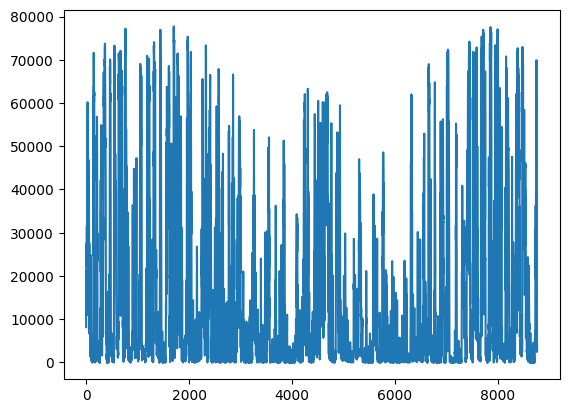

In [ ]:
plt.plot(preds_yg)

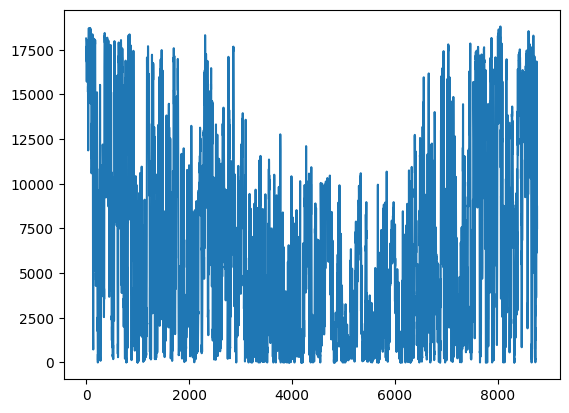

In [29]:
plt.plot(preds_gj)

In [30]:
gj = submission.loc[submission['plant_name'] == '경주풍력']
yg = submission.loc[submission['plant_name'] == '영광풍력']

In [31]:
gj['energy_kwh'] = preds_gj
yg['energy_kwh'] = preds_yg

In [32]:
final_submission = pd.concat([gj, yg], axis=0)
#final_submission.to_csv(config.input_path + "씽씽 불어라팀 5차 중간평가 제출(모델3).csv", index=False)